## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In [19]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2]  = np.mgrid[0:9,0:6].T.reshape(-1,2)

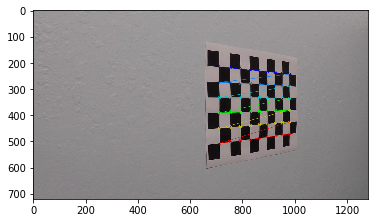

In [2]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for i,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                   (1280,720), None, None)

## Distortion correction

In [42]:
def undistort_img(img, mtx, dist):
    # 1) Undistort using mtx and dist
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort_img

In [39]:
for filename in images:
    image = mpimg.imread(filename)
    undistorted_img = undistort_img(image,mtx,dist)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/'+filename.split('/')[-1], undistorted_img)

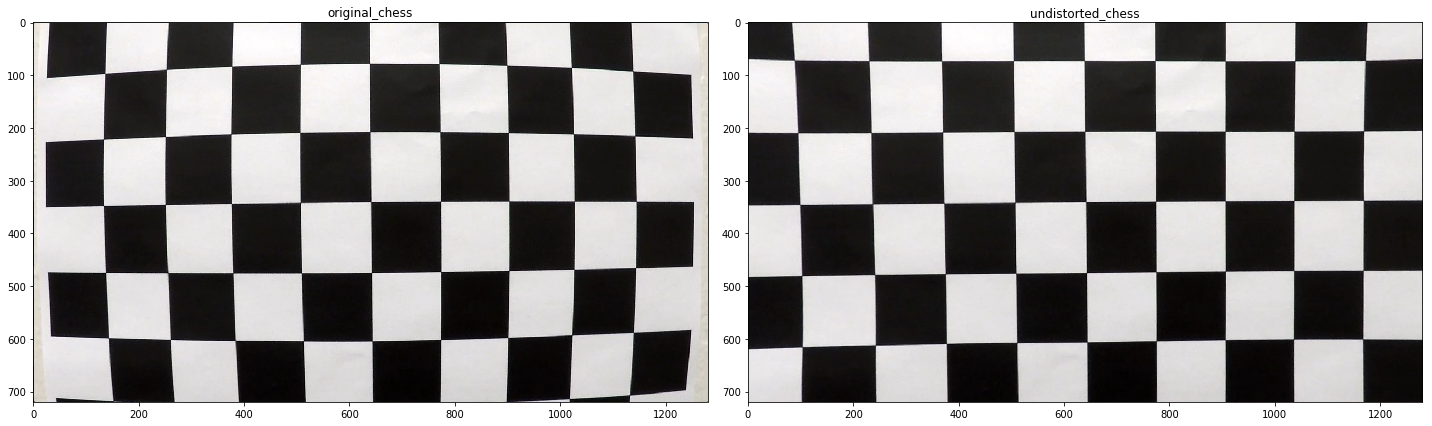

In [41]:
original_chess = mpimg.imread('camera_cal/calibration1.jpg')
undistorted_chess = mpimg.imread('output_images/calibration1.jpg')
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(original_chess)
plt.title('original_chess')
plt.subplot(122)
plt.imshow(undistorted_chess)
plt.title('undistorted_chess')
fig.tight_layout()
plt.show()

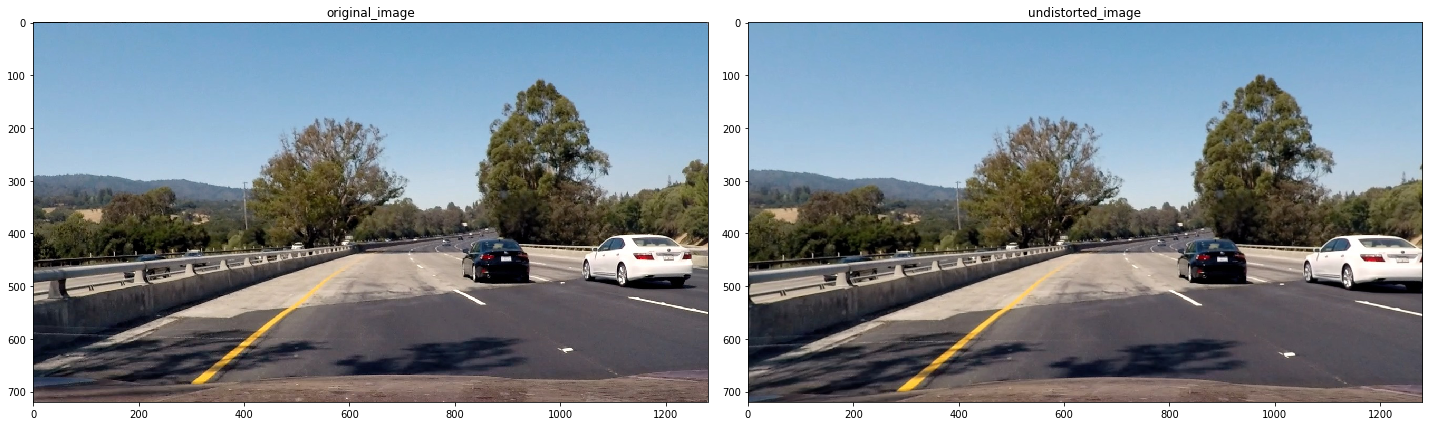

In [43]:
original_image = mpimg.imread('test_images/test4.jpg')
undistorted_image = undistort_img(original_image, mtx, dist)
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(original_image)
plt.title('original_image')
plt.subplot(122)
plt.imshow(undistorted_image)
plt.title('undistorted_image')
fig.tight_layout()
plt.show()

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    hls_img_s = hls_img[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls_img_s)
    binary_output[(hls_img_s > thresh[0]) & (hls_img_s <= thresh[1])]=1
    # 3) Return a binary image of threshold result
    return binary_output

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray_img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_abs_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_abs_sobelxy)
    binary_output[(scaled_abs_sobelxy>mag_thresh[0])&(scaled_abs_sobelxy<mag_thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return binary_output

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx =np.abs(cv2.Sobel(gray_img,cv2.CV_64F,1,0,ksize=sobel_kernel))
    sobely = np.abs(cv2.Sobel(gray_img,cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_grad = np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad>thresh[0])&(dir_grad<thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return binary_output

## Color/gradient threshold

In [9]:
def color_gradient(img, s_thresh=(180, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combine_binary = np.zeros_like(s_binary)
    combine_binary[((sxbinary == 1) | (s_binary == 1))] = 255
    return combine_binary

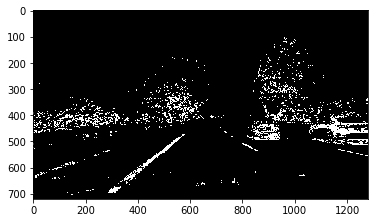

In [46]:
binary_image = color_gradient(undistorted_image, s_thresh=(180, 255), sx_thresh=(30, 100))
plt.imshow(binary_image,cmap='gray')

In [47]:
#  define 4 source points src = np.float32([[,],[,],[,],[,]])
src = np.float32([[597.77,455.42],[697.73,455.42],[1042.9,680.16],[274.90,680.16]]) 

#  define 4 destination points dst = np.float32([[,],[,],[,],[,]])
dst = np.float32([[340,0],[940,0],[940,720],[340,720]])
def warper(img,src,dst):
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped_image = cv2.warpPerspective(img,M,(1280,720),flags=cv2.INTER_LINEAR) 
    return warped_image

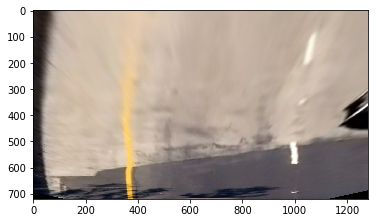

In [48]:
warped_image = warper(undistorted_image,src,dst)
plt.imshow(warped_image)

In [11]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



In [12]:
def slide_window(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx

In [13]:
def find_line(binary_warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_fit = left_line.fit
    right_fit = right_line.fit
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx

## Pipeline

In [14]:
# For videos

def pipeline(img,nx,ny,mtx,dist,src,dst):
    undistort_image = undistort_img(img, nx, ny, mtx, dist)
    
    combine_binary = color_gradient(undistort_image, s_thresh=(180, 255), sx_thresh=(20, 100))
    
#     vertices = np.array([[(0.05*img.shape[1],0.92*img.shape[0]),(0.5*img.shape[1],0.57*img.shape[0]),(0.52*img.shape[1],0.57*img.shape[0]),(0.93*img.shape[1],0.92*img.shape[0])]],dtype=np.int32)
#     masked_image = region_of_interest(combine_binary, vertices);
    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    binary_warped = cv2.warpPerspective(combine_binary,M,(1280,720),flags=cv2.INTER_LINEAR) 
    
    if (left_line.fit!=None) & (left_line.undetected < 3):
        leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx = find_line(binary_warped)
    else:
        leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx = slide_window(binary_warped)
#         print("---slide--window----")
    

    if (np.absolute(right_fitx-left_fitx-600)<80).all():
#         print(right_fitx-left_fitx-600)
        left_line.undetected = 0
        right_line.undetected = 0
    
        left_line.allx = leftx
        left_line.ally = lefty
        left_line.fit = left_fit
        left_line.fitx = left_fitx
    

        right_line.allx = rightx
        right_line.ally = righty
        right_line.fit = right_fit
        right_line.fitx = right_fitx
    
    else:
#         print(">>>>>>>>>>>>>>")
        left_line.undetected = left_line.undetected + 1
        right_line.undetected = right_line.undetected + 1
        if left_line.fitx.any():
            left_fitx = left_line.fitx
            right_fitx = right_line.fitx
    
#     print('##################')
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-10,left_fitx[::-1]+10),axis=0),
                                  np.concatenate((ploty,ploty[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-10,right_fitx[::-1]+10),axis=0),
                                  np.concatenate((ploty,ploty[::-1]),axis=0))),np.int32)
    center_lane = np.array(list(zip(np.concatenate((left_fitx+10,right_fitx[::-1]-10),axis=0),
                                  np.concatenate((ploty,ploty[::-1]),axis=0))),np.int32)
#     print(left_lane)
    
    road = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[255,0,0])
    cv2.fillPoly(road,[center_lane],color=[0,255,0])
    
    road_warped = cv2.warpPerspective(road,Minv,(1280,720),flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(img,1.0,road_warped,1,0.0)


    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 24./720. # meters per pixel in y dimension
    xm_per_pix = 4./600. # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    camera_center = (left_fitx[-1]+right_fitx[-1])/2

    center_diff = (camera_center-binary_warped.shape[1]/2.)*xm_per_pix
    
    cv2.putText(result,'Radius of curvature = '+str(round(left_curverad,3))+'m',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result,'vehicle is '+str(round(center_diff,3))+'m of center',(50,100),
                cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    output = np.array(result)
    return output
    

In [24]:
# For images only

def pipeline_1(img,nx,ny,mtx,dist,src,dst):
    undistort_image = undistort_img(img, nx, ny, mtx, dist)
    
    combine_binary = color_gradient(undistort_image, s_thresh=(180, 255), sx_thresh=(20, 100))
    
#     vertices = np.array([[(0.05*img.shape[1],0.92*img.shape[0]),(0.5*img.shape[1],0.57*img.shape[0]),(0.52*img.shape[1],0.57*img.shape[0]),(0.93*img.shape[1],0.92*img.shape[0])]],dtype=np.int32)
#     masked_image = region_of_interest(combine_binary, vertices);
    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    binary_warped = cv2.warpPerspective(combine_binary,M,(1280,720),flags=cv2.INTER_LINEAR) 
    

    leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx = slide_window(binary_warped)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-10,left_fitx[::-1]+10),axis=0),
                                  np.concatenate((ploty,ploty[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-10,right_fitx[::-1]+10),axis=0),
                                  np.concatenate((ploty,ploty[::-1]),axis=0))),np.int32)
    center_lane = np.array(list(zip(np.concatenate((left_fitx+10,right_fitx[::-1]-10),axis=0),
                                  np.concatenate((ploty,ploty[::-1]),axis=0))),np.int32)
#     print(left_lane)
    
    road = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[255,0,0])
    cv2.fillPoly(road,[center_lane],color=[0,255,0])
    
    road_warped = cv2.warpPerspective(road,Minv,(1280,720),flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(img,1.0,road_warped,1,0.0)

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 24./720. # meters per pixel in y dimension
    xm_per_pix = 4./600. # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    camera_center = (left_fitx[-1]+right_fitx[-1])/2
#     print(camera_center)
    center_diff = (camera_center-binary_warped.shape[1]/2.)*xm_per_pix
#     print(center_diff)
    
    cv2.putText(result,'Radius of curvature = '+str(round(left_curverad,3))+'m',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result,'vehicle is '+str(round(center_diff,3))+'m of center',(50,100),
                cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

#     cv2.imwrite('result.jpg',result)
#     output = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
    output = np.array(result)
    return output

In [15]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.undetected = 0  
        self.fit = None
        # x values of the last n fits of the line
        self.fitx = np.array([],np.int32) 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    src = np.float32([[597.77,455.42],[697.73,455.42],[1042.9,680.16],[274.90,680.16]]) 
    dst = np.float32([[340,0],[940,0],[940,720],[340,720]])
    nx = 9
    ny = 6
    mtx_t = np.array([[  1.15396093e+03 ,  0.00000000e+00  , 6.69705357e+02],
                      [  0.00000000e+00  , 1.14802496e+03 ,  3.85656234e+02],
                      [  0.00000000e+00 ,  0.00000000e+00  , 1.00000000e+00]])
    dist_t = np.array([[ -2.41017956e-01,  -5.30721173e-02 , -1.15810355e-03 , -1.28318856e-04,2.67125290e-02]])
    result = pipeline(image,nx,ny,mtx_t,dist_t,src,dst)
    # you should return the final output (image where lines are drawn on lanes)

    return result

In [25]:
def process_image_1(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    src = np.float32([[597.77,455.42],[697.73,455.42],[1042.9,680.16],[274.90,680.16]]) 
    dst = np.float32([[340,0],[940,0],[940,720],[340,720]])
    nx = 9
    ny = 6
    mtx_t = np.array([[  1.15396093e+03 ,  0.00000000e+00  , 6.69705357e+02],
                      [  0.00000000e+00  , 1.14802496e+03 ,  3.85656234e+02],
                      [  0.00000000e+00 ,  0.00000000e+00  , 1.00000000e+00]])
    dist_t = np.array([[ -2.41017956e-01,  -5.30721173e-02 , -1.15810355e-03 , -1.28318856e-04,2.67125290e-02]])
    result = pipeline_1(image,nx,ny,mtx_t,dist_t,src,dst)
    # you should return the final output (image where lines are drawn on lanes)

    return result

In [26]:
def process_test_imgs(dir):
    test_filenames = glob.glob(dir)
    print(test_filenames)
    for test_filename in test_filenames:
        test_image = mpimg.imread(test_filename)
        image = process_image_1(test_image)
        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite('output_images/'+test_filename.split('/')[-1], image)

In [27]:
test_img_dir = 'test_images/*.jpg'
process_test_imgs(test_img_dir)

['test_images/test6.jpg', 'test_images/test5.jpg', 'test_images/test4.jpg', 'test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test2.jpg', 'test_images/straight_lines2.jpg', 'test_images/straight_lines1.jpg']


In [37]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_video(video_dir):
    output = './output_video.mp4'
    clip1 = VideoFileClip(video_dir)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output, audio=False)

In [38]:
video_dir = 'project_video.mp4'
left_line = Line()
right_line = Line()
process_video(video_dir)

[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


100%|█████████▉| 1260/1261 [02:43<00:00,  7.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 

CPU times: user 10min 42s, sys: 52.3 s, total: 11min 34s
Wall time: 2min 44s


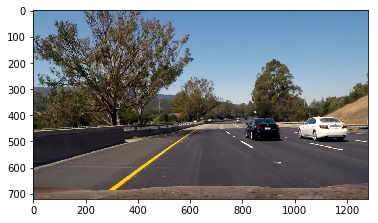

In [260]:
test_img = cv2.imread('../test_images/test6.jpg')
test_img_rgb = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
plt.imshow(test_img_rgb)

In [219]:
mtx_t = np.array([[  1.15396093e+03 ,  0.00000000e+00  , 6.69705357e+02],
 [  0.00000000e+00  , 1.14802496e+03 ,  3.85656234e+02],
 [  0.00000000e+00 ,  0.00000000e+00  , 1.00000000e+00]])
print(mtx_t)
print(dist)

[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


In [263]:
nx = 9
ny = 6

undistort_image,result = pipeline(test_img,nx,ny,mtx,dist,src,dst)

16468.5212728 m 205.624293394 m
684.307433324
0.295382888824


(720, 1280, 3)


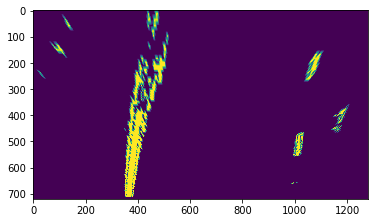

In [264]:
print(result.shape)
plt.imshow(undistort_image)

## And so on and so forth...

In [92]:
a = []
a.append((1,2))
a.append((2,3))
a.append((3,4))
b = []
b.append((1,1))
b.append((2,2))
b.append((3,3))
print(a)
print(b)
c = []
c.append(a)
c.append(b)
print(c)

[(1, 2), (2, 3), (3, 4)]
[(1, 1), (2, 2), (3, 3)]
[[(1, 2), (2, 3), (3, 4)], [(1, 1), (2, 2), (3, 3)]]


In [98]:
print(np.average(c[-1:],axis=0))

[[ 1.  1.]
 [ 2.  2.]
 [ 3.  3.]]


In [103]:
d = np.array([1,2,3,4])
e = np.concatenate((d+2,d[::-1]-2),axis=0)
print(d-1)
print(e)

[0 1 2 3]
[ 3  4  5  6  2  1  0 -1]


In [126]:
print(np.array(list(zip(e,e))))

[[ 3  3]
 [ 4  4]
 [ 5  5]
 [ 6  6]
 [ 2  2]
 [ 1  1]
 [ 0  0]
 [-1 -1]]


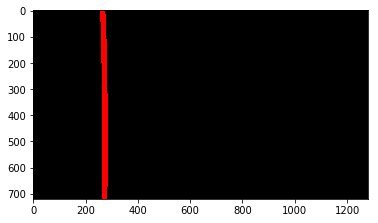

In [135]:
pic = np.zeros_like(test_img)
a = np.array([[ 256.67845121,0.0       ],
     [ 259.57812703,89.875     ],
     [ 261.87863117,179.75      ],
     [ 263.57996363,269.625     ],
     [ 264.68212441,359.5       ],
     [ 265.18511351,449.375     ],
     [ 265.08893092,539.25      ],
     [ 264.39357665,629.125     ],
     [ 263.0990507,719.        ],
     [ 283.0990507,719.        ],
     [ 284.39357665,629.125     ],
     [ 285.08893092,539.25      ],
     [ 285.18511351,449.375     ],
     [ 284.68212441,359.5       ],
     [ 283.57996363,269.625     ],
     [ 281.87863117,179.75      ],
     [ 279.57812703,89.875     ],
     [ 276.67845121,0.0        ]],'int32')
cv2.fillPoly(pic,[a],color=[255,0,0])
plt.imshow(pic)

In [277]:
class Test():
    def __init__(self):
        # was the line detected in the last iteration?
        self.first = []
    def abc(self):
        self.first.append(1)
       

In [279]:
test2 = Test()
test2.abc()
print(test2.first)

[1]


In [287]:
def aa():
    test2.abc()
    a = test2.first
    return a

In [288]:
print(aa())

[1, 1, 1, 1]


In [289]:
print(test2.first)

[1, 1, 1, 1]


In [465]:
aaa = np.array([[1,2],[3,4],[5,6]])
bbb = np.array([])
if bbb.any():
    print(bbb)
else:
    print(aaa)

[[1 2]
 [3 4]
 [5 6]]


In [461]:
ccc=np.array([[2,3],[4,5],[5,6]])

In [460]:
bbb = aaa
print(bbb)

[[1 2]
 [3 4]
 [5 6]]


In [462]:
bbb = ccc
print(bbb)

[[2 3]
 [4 5]
 [5 6]]


In [310]:
def keep_three(a,b):
    if len(a) >= 3:
        a[0]=a[1]
        a[1]=a[2]
        a[2]=b
    else:
        a.append(b)

In [393]:
a=None
b =1
if (a == None) & (b<2) & (False):
    print(a)
else:
    print("No a")

No a


In [405]:
print("a={}".format(b))

a=1


In [34]:
import datetime

time_stamp = datetime.datetime.now().strftime('%y-%m-%d %H:%M:%S')
print(time_stamp)

18-06-22 07:44:04
